## Goal is to calibrate entire test set

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import util as ut
import numpy as np

### Get the list of test files for calibration

In [5]:
test_set = ut.ChordsTestSet()

In [27]:
test_set.audio_fp(0)

'/scratch/qx244/data/eric_chords_21sp/audio/TRAIIEF149E3861F6C.mp3'

In [28]:
test_set.ref_fp(0)

'/scratch/qx244/data/eric_chords_21sp/references/TRAIIEF149E3861F6C.jams'

In [5]:
test_set.npz_fp(0)

'/scratch/qx244/data/eric_chords_21sp/crema_out/TRAIIEF149E3861F6C.npz'

### process each file into soft-max output and label pair

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import process as prs
from tqdm import tqdm

In [6]:
for i in tqdm(range(len(test_set))):
    y, x = prs.chord_file_processor(test_set.audio_fp(i), test_set.ref_fp(i))
    with open(test_set.npz_fp(i), 'wb') as f:
        np.savez(f, y=y, x=x)

  0%|          | 0/244 [00:00<?, ?it/s]

100%|██████████| 244/244 [2:07:39<00:00, 31.39s/it]


### Calibrate and analyze result

In [60]:
from scipy.optimize import minimize_scalar

In [116]:
import matplotlib.pyplot as plt

In [6]:
test_set = ut.ChordsTestSet()
test_set.npz_fp(0)

'/scratch/qx244/data/eric_chords_21sp/crema_out/TRAIIEF149E3861F6C.npz'

In [118]:
## Open all the saved npz files (crema outputs) and save them in 2 big arrays x_all and y_all

l = len(test_set)

first_iter = True
for i in tqdm(range(l)):
    data = np.load(test_set.npz_fp(i))
    if first_iter:
        first_iter = False
        x_all = data['x'][:len(y_all)]
        y_all = data['y'][:len(x_all)] if data['y'].ndim == 1 else data['y'][0, :len(x_all)]
    else:
        new_y = data['y'][:len(data['x'])] if data['y'].ndim == 1 else data['y'][0, :len(data['x'])]
 
        x_all = np.concatenate((x_all, data['x'][:len(new_y), :]), axis=0)
        y_all = np.concatenate((y_all, new_y), axis=0)

100%|██████████| 244/244 [00:01<00:00, 193.98it/s]


In [121]:
x_all.shape

(580453, 13)

In [122]:
y_all.shape

(580453,)

In [123]:
res = minimize_scalar(ut.better_track_nll, 
                      args=(y_all, x_all),
                      bounds=(0, 1),
                      method='bounded')

In [127]:
res.x

0.7956625610036311

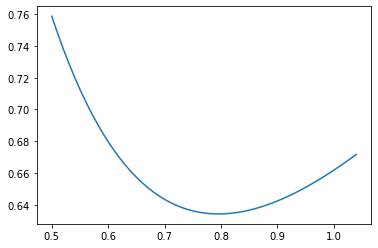

In [125]:
plt.plot(np.arange(0.5,1.05,0.01),
         [ut.better_track_nll(b, y_all, x_all) 
          for b in np.arange(0.5,1.05,0.01)])

In [126]:
## ECE Graphs:

In [128]:
x_all_calibrated = ut.better_calibrate(res.x, x_all)

In [145]:
original = ut.CalibrationBenchmark(x_all, y_all, m=15)
calibrated = ut.CalibrationBenchmark(x_all_calibrated, y_all, m=15)

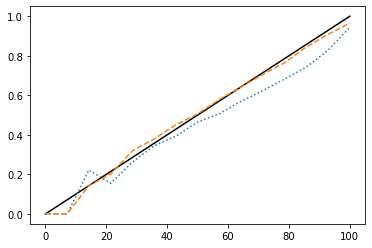

In [155]:
plt.plot(np.linspace(0, 100, num=15, endpoint=True), np.linspace(0, 1, num=15, endpoint=True), 'k')
plt.plot(np.linspace(0, 100, num=15, endpoint=True), original.bin_accuracy(), ':')
plt.plot(np.linspace(0, 100, num=15, endpoint=True), calibrated.bin_accuracy(), '--')
plt.show()

In [153]:
import matplotlib
matplotlib.__version__

'3.3.4'

In [147]:
original.ece()

0.050725811038472415

In [148]:
calibrated.ece()

0.00521207178114321

## Next up, is working with Madmom

In [6]:
jams.load(test_set.ref_fp(0))

NameError: name 'jams' is not defined